# Data Analysis
Author: Leon Yin<br>
Date: 2020-2-03<br>

This notebook analyses the results of the element categorization and area estimations from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
import os
import sys
import json
import time
import glob
import tempfile
import warnings
import inspect
from collections import Counter
from multiprocessing import Pool
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from bs4 import BeautifulSoup
from tqdm import tqdm
from IPython.display import display

sys.path.append("..")
from utils.config import (
    google_domains,
    cat2color
)

In [4]:
# input
fn_metadata = '../data/intermediary/element_metadata_15k.jsonl.gz'
# fn_metadata = '/mnt/n1p1/data/platforms/google/experiment/intermediary__V1/element_metadata_15k.jsonl.gz'
# output
output_dir = '../data/output'
tables_dir = os.path.join(output_dir, 'tables/')
figure_dir = os.path.join(output_dir, 'figures/')
appendix_dir = os.path.join(output_dir, 'appendix/')

for d in [tables_dir, figure_dir, appendix_dir]:
    os.makedirs(d, exist_ok=True)

In [5]:
df = pd.read_json(fn_metadata, lines=True, 
                  compression='gzip')

In [6]:
df.fn_input.nunique()

15269

In [7]:
print(json.dumps(df.sample(1).iloc[-1].to_dict(), 
                 indent=2))

{
  "text": "Total Wine \u203a beer \u203a white-claw-har...White Claw Hard Seltzer Lime | Total Wine & MoreShop White Claw Hard Seltzer Lime at the best prices. Explore thousands of wines, spirits and beers, and shop online for delivery or pickup in a\u00a0... 4.0  (3)  \u00b7 $8.49 \u00b7 In stock",
  "link": "https://www.totalwine.com/beer/seltzers-flavored-beverages/hard-seltzer/white-claw-hard-seltzer-lime/p/163273126",
  "domain": "totalwine.com",
  "xpath": "/html/body/div[10]/div/div[6]/div/div[3]/div/div[4]/div[2]",
  "category": "organic-search_result",
  "tag": "div",
  "attrs": {
    "data-hveid": "CAgQCQ"
  },
  "dimensions": {
    "height": 173.0,
    "width": 347.0
  },
  "location": {
    "x": 8,
    "y": 3289
  },
  "area_page": 60031.0,
  "fn_input": "../data/input/google_search/iPhone-X/2019/12/06/White-Claw-Hard-Seltzer/html/webpage_raw.html",
  "position_last_element": 4200.0,
  "fn_metadata": "../data/intermediary/google_search/iPhone-X/2019/12/06/White-Claw-Hard-

In [8]:
# first glance
df.groupby('label') \
  .q1_area.sum() \
  .sort_values(ascending=False) / df.q1_area.sum()

label
link       0.377268
organic    0.236767
answer     0.231890
amp        0.106581
ads        0.047493
Name: q1_area, dtype: float64

In [9]:
# full page
df.groupby('label') \
  .area_page.sum() \
  .sort_values(ascending=False)/ df.area_page.sum()

label
organic    0.447602
link       0.275109
answer     0.134530
amp        0.133131
ads        0.009628
Name: area_page, dtype: float64

## Breakdown of area and frequency for each category

In [10]:
# get area per standardized category
cat_area_ = (df.groupby('category_standard')
               .area_page.sum()
               .divide(df.area_page.sum()))

cat_area =(df.groupby('category_standard')
             .q1_area.sum()
             .divide(df.q1_area.sum()))

In [11]:
(df.groupby('category_standard')
             .q1_area.sum()
             .divide(df.q1_area.sum()))

category_standard
ads                             0.047493
amp-card                        0.099080
amp-search_result               0.000176
amp-search_result_3             0.004296
amp-visual_stories              0.003029
google-answer                   0.196754
google-expandable-answer        0.035136
google-images                   0.121809
google-knowledge-panel-links    0.054374
google-maps                     0.012783
google-misc                     0.090981
google-search                   0.067852
google-video                    0.029470
organic                         0.105165
organic-search_result           0.131602
Name: q1_area, dtype: float64

In [12]:
n_pages = df[df.q1_area != 0].fn_input.nunique()

In [13]:
# number of elements on first glance
cat_count = Counter()
for fn, _df in df[df.q1_area != 0].groupby('fn_input'):
    cat_count.update(_df.category_standard.unique())
df_wc = pd.DataFrame(cat_count.most_common(50),
                     columns=['category_standard', 'count'])
df_wc['freq'] = df_wc['count'] / n_pages 

# number of elements on full page
cat_count_ = Counter()
for fn, _df in df[df.area_page != 0].groupby('fn_input'):
    cat_count_.update(_df.category_standard.unique())
df_wc_ = pd.DataFrame(cat_count_.most_common(50),
                     columns=['category_standard', 'count_page'])
df_wc_['freq_page'] = df_wc_['count_page'] / n_pages 

In [14]:
cat_amp = df[df.label == 'amp'].category_standard.unique()
cat_sd = df[df.label == 'link'].category_standard.unique()
cat_rt = df[df.label == 'answer'].category_standard.unique()
cat_ad = df[df.label == 'ads'].category_standard.unique()
cat_og = df[df.label == 'organic'].category_standard.unique()

In [15]:
def format_number(x):
    """Makes it nice for printing"""
    x = x * 100
    x = round(x, 2)
    return f"{x}%"

In [16]:
def breakdown(categories : list(), 
              col='category_standard'):
    """Shows the area coverage and page frequency for each category  """
    full_page =df_wc_[df_wc_[col].isin(categories)] \
            .join(cat_area_.to_frame(),
                  on=col,
                  how='left')

    output = (df_wc[df_wc[col].isin(categories)]
        .join(cat_area.to_frame(),
              on=col,
              how='left')
        .sort_values(by=['q1_area'], 
                     ascending=False)
        .reset_index(drop=True)
        .merge(full_page)
    )
    
    output = output[[c for c in output.columns if 'count' not in c]]
        
    fg_area = output['q1_area'].sum()
    fp_area = output['area_page'].sum()
    
    output = output.append(
        {'category_standard' : 'Total', 
         'freq' : np.nan, 
         'q1_area' : fg_area, 
         'freq_page' : np.nan, 
         'area_page' : fp_area},
        ignore_index=True
    )
    return output.set_index(col)


## Breakdown of area and frequency for each category

In [17]:
columns = [
   ('Above the fold', 'area'),
   ('Above the fold' , 'area'),
   ('Full page', 'freq'),
   ('Full page' , 'area'),
]

In [18]:
total_area = df['q1_area'].sum()
total_area_fp = df['area_page'].sum()
n_pages = df.fn_input.nunique()

In [19]:
label2publabel = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'organic' : 'Organic',
    'amp' : 'AMP',
    'ads' : 'Ads'
}

In [20]:
labels_in_order = [
    'organic',
    'amp',
    'answer',
    'link',
    'ads'
]

In [21]:
df_cat_agg = pd.DataFrame()
for categories in [cat_ad, cat_amp, cat_rt, cat_sd, cat_og]:
    output = breakdown(categories)
    df_cat_agg = df_cat_agg.append(output)
    
    output.columns = pd.MultiIndex.from_tuples([
       ('Above the fold', 'freq'),
       ('Above the fold' , 'area'),
       ('Full page', 'freq'),
       ('Full page' , 'area'),
    ])
    for c, dtype in output.dtypes.items():
        if pd.api.types.is_numeric_dtype(output[c]):
            output[c] = output[c].apply(format_number)
    
    display(output)

Above the fold        Full page       
                            freq   area      freq   area
category_standard                                       
ads                        8.53%  4.75%     9.51%  0.96%
Total                       nan%  4.75%      nan%  0.96%

Above the fold         Full page        
                              freq    area      freq    area
category_standard                                           
amp-card                    22.71%   9.91%    56.19%   4.28%
amp-search_result_3          1.93%   0.43%    66.61%    8.6%
amp-visual_stories           3.38%    0.3%     5.51%    0.1%
amp-search_result            0.18%   0.02%     4.92%   0.34%
Total                         nan%  10.66%      nan%  13.31%

Above the fold         Full page        
                                   freq    area      freq    area
category_standard                                                
google-answer                    71.64%  19.68%    93.68%   5.95%
google-expandable-answer         24.53%   3.51%    89.74%    7.5%
Total                              nan%  23.19%      nan%  13.45%

Above the fold         Full page        
                                       freq    area      freq    area
category_standard                                                    
google-images                        72.38%  12.18%     85.8%   2.63%
google-misc                          88.96%    9.1%    99.23%   3.91%
google-search                        39.33%   6.79%    99.99%  15.67%
google-knowledge-panel-links         68.19%   5.44%     72.7%   1.09%
google-video                         17.12%   2.95%     59.4%   3.83%
google-maps                           6.61%   1.28%      9.6%   0.38%
Total                                  nan%  37.73%      nan%  27.51%

Above the fold         Full page        
                                freq    area      freq    area
category_standard                                             
organic-search_result          36.6%  13.16%    99.97%   38.2%
organic                       78.33%  10.52%    95.15%   6.56%
Total                           nan%  23.68%      nan%  44.76%

In [22]:
total_area = df['q1_area'].sum()

In [23]:
data = {}
for label in labels_in_order:
    _df = df[df.label == label]
    area = (_df['q1_area'].sum() / total_area)
    freq = _df[_df['q1_area'] != 0].fn_input.nunique() / n_pages
    
    area_page = (_df['area_page'].sum() / total_area_fp)
    freq_page = _df[_df['area_page'] != 0].fn_input.nunique() / n_pages
    
    data[label2publabel.get(label,label)] = {
        ('Above the fold', 'area') : area,
        ('Above the fold', 'freq') : freq,
        ('First page', 'area') : area_page,
        ('First page', 'freq') : freq_page,
    }
    
cat_breakdown = pd.DataFrame(data).T
cat_breakdown.columns = pd.MultiIndex.from_tuples([
    ('Above the fold', 'area'),
    ('Above the fold', 'freq'),
    ('First page', 'area'),
    ('First page', 'freq'),
])
print((cat_breakdown * 100).round(1).astype(str) + '%')

               Above the fold        First page        
                         area   freq       area    freq
Organic                 23.7%  90.3%      44.8%  100.0%
AMP                     10.7%  27.0%      13.3%   80.7%
Google Answer           23.2%  81.8%      13.5%   99.4%
Google Product          37.7%  95.9%      27.5%  100.0%
Ads                      4.7%   8.5%       1.0%    9.5%


In [24]:
fn_cats = '../data/output/tables/T1_area_freq_by_category.csv'
cat_breakdown.to_csv(fn_cats)

## Ratios

In [25]:
labels_in_order = [
    'organic',
    'amp',
    'answer',
    'link',
    'ads'
]

In [26]:
area_cols = ['q1_area', 'q2_area', 
             'q3_area', 'q4_area',
             'q5_area', 'area_page']

In [27]:
new_index = [
    'Top of page',
    'Second fifth',
    'Middle of Page',
    'Fourth fifth',
    'Bottom of page',
]

label2label = {
    'organic' : 'Non-Google',
    'amp' : 'AMP',
    'answer' : 'Google Answer',
    'link' : 'Google Product',
    'ads' : "Ads",
}

In [28]:
cat2color.items()

dict_items([('organic', '#b2b2b2'), ('amp', '#6cb1ee'), ('answer', '#34a853'), ('link', '#fbbc05'), ('ads', '#ea4335')])

In [29]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label2label.get(label),
                          markerfacecolor=c, markersize=10)
                   for label, c in cat2color.items()][::-1]

In [30]:
data = []
for q in tqdm(area_cols):
    _df = df[df[q] > 0]
    total_area = _df[q].sum()
    row = {'quantile' : q.replace('_area', '')}
    for label in labels_in_order:
        __df = _df[_df.label == label]
        area = (__df[q].sum() / total_area)
        freq = __df.fn_input.nunique() / n_pages
        row['area', label2publabel.get(label,label)] = area
        row['freq', label2publabel.get(label,label)] = freq
    data.append(row)

100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


In [31]:
quantiles = pd.DataFrame(data)
quantiles.set_index('quantile', inplace=True)
quantiles.columns = pd.MultiIndex.from_tuples(quantiles.columns)

In [32]:
quantiles.loc[:,quantiles.columns.get_level_values(0) == 'area'].iloc[:-1]

area                                                 
           Organic       AMP Google Answer Google Product       Ads
quantile                                                           
q1        0.236767  0.106581      0.231890       0.377268  0.047493
q2        0.508164  0.102970      0.140354       0.247772  0.000740
q3        0.513991  0.125007      0.126538       0.234445  0.000019
q4        0.677709  0.219281      0.032135       0.069943  0.000932
q5        0.255834  0.099288      0.163704       0.477046  0.004128

In [33]:
[cat2color.get(c) for c in labels_in_order]

['#b2b2b2', '#6cb1ee', '#34a853', '#fbbc05', '#ea4335']

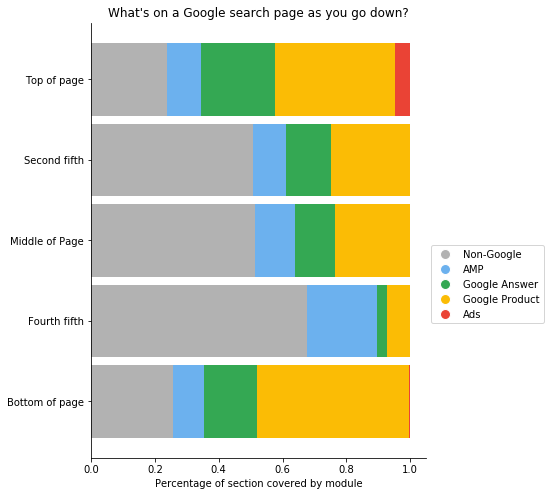

In [36]:
viz = quantiles.loc[:,quantiles.columns.get_level_values(0) == 'area'].iloc[:-1]
viz.index = new_index
ax = viz[::-1].plot(
    kind='barh', 
    stacked=True,
    legend=False,
    figsize=(6, 8),
    width=.9,
    color = [cat2color.get(c) for c in labels_in_order],
    title="What's on a Google search page as you go down?"
)

ax.set_xlabel("Percentage of section covered by module")
# plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# ax.xaxis.set_visible(False)
ax.legend(handles=legend_elements[::-1],
          bbox_to_anchor=(1.0, 0.5))
# ax.legend(loc='upper center',
#           handles=legend_elements,
#           ncol=5, handletextpad=0.0)

## Histogram of Google-occupied pixels

\begin{equation}
X_{o} = \frac{o}{o + g + amp + ad}
\end{equation}

\begin{equation}
X_{o} = \frac{tsl}{o + g + amp + ad}
\end{equation}

Where <br>
&nbsp;&nbsp;&nbsp;&nbsp; $X_{o}$: is the percentage of real estate that occupy non-Google elements.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $g$: is the total sum of variable real estate pixels occupied by Google links and answers.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $o$: is the total sum of variable real estate pixels occupied by Organic links.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $ad$: is the total sum of variable real estate pixels occupied by ads.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $amp$: is the total sum of variable real estate pixels occupied by AMP.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $tsl$: is the total sum of variable real estate pixels occupied by traditional organic, amp and YouTube search listings.<br>

In [37]:
blue_link_categories = [
    'organic-search_result',
    'amp-search_result',
    'link-youtube_search_result'
]

In [38]:
pixels = {c : list() for c in area_cols}
for search, df_ in tqdm(df.groupby('fn_input')):
    for col in area_cols:
        # get sum of pixels for each label.
        ad = df_[df_.label == 'ads'][col].sum()
        o = df_[df_.label == 'organic'][col].sum()
        o_sr =  df_[
            df_.category_standard.isin(blue_link_categories)
        ][col].sum()
        g = df_[(df_.label == 'link') | 
                (df_.label == 'answer')][col].sum()
        amp = df_[df_.label == 'amp'][col].sum()
        
        # equations
        e1 =  o / (g + ad + o + amp)
        e2 = o_sr / (g + ad + o + amp)

        row = {
            'search_term' : search,
            'ad' : ad,
            'o' : o,
            'g' : g,
            'amp' : amp,
            'e1' : e1,
            'e2' : e2,
        }

        pixels[col].append(row)
    
df_pixels = pd.DataFrame(pixels['q1_area'])
df_pixels_fp = pd.DataFrame(pixels['area_page'])

100%|██████████| 15269/15269 [03:41<00:00, 68.90it/s]


In [39]:
df_pixels = pd.DataFrame(pixels['q1_area'])
df_pixels_fp = pd.DataFrame(pixels['area_page'])

In [40]:
df_pixels.e1.fillna(0, inplace=True)
df_pixels.e2.fillna(0, inplace=True)

In [41]:
fn_pixels = '../data/intermediary/pixels_above_the_fold.csv'
fn_pixels_page = '../data/intermediary/pixels_page.csv'

In [42]:
df_pixels.to_csv(fn_pixels, index=False)
df_pixels_fp.to_csv(fn_pixels_page, index=False)

In [43]:
# df_pixels[
#     (df_pixels.ad > 1) &
#     (df_pixels.o > 1) &
#     (df_pixels.g > 1) &
#     (df_pixels.amp > 1)
# ].search_term.head(20).tolist()

In [44]:
def hist(series, color='black', 
         title=None, 
         fn_out=None,
         left_right_annotations = (None, None)):
    ax = series.plot(kind='hist', 
                           figsize=(10,6),
                           bins=10, 
                           rwidth=.95,
                           color=color,
                           alpha=.9,
                           title=title)

    ax.tick_params(axis="both", which="both", bottom="off", 
                   top="off", labelbottom="on", left="off", 
                   right="off", labelleft="on")

    plt.annotate(left_right_annotations[0], 
                 (0.04, 0), (0, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')
    plt.annotate(left_right_annotations[-1], 
                 (.75, 0), (.75, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')

    ax.set_ylabel("Count of search pages")

    ax.set_axisbelow(True)
    plt.gca().yaxis.grid(True)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if fn_out:
         plt.savefig(fn_out)
    
    return ax

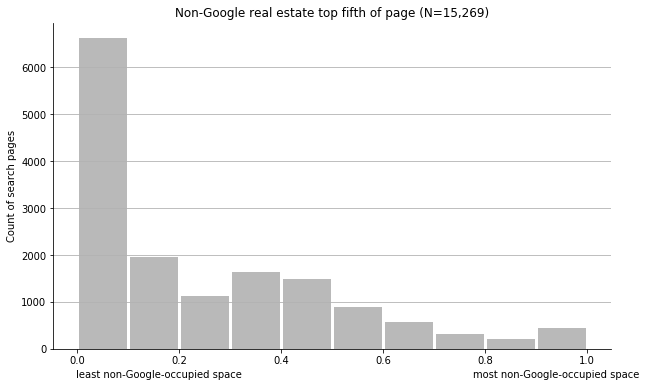

In [45]:
hist(df_pixels.e1,
     left_right_annotations = ('least non-Google-occupied space',
                               'most non-Google-occupied space'),
     color=cat2color['organic'],
     title = f'Non-Google real estate top fifth of page (N={len(df_pixels):,})',
     fn_out='../data/output/figures/eq1_abv.png');

In [46]:
# What percentage of pages have 10% or less of the page occupied by Google?
len(df_pixels[df_pixels.e1 <= .1]) / len(df_pixels) * 100

43.388565066474555

In [47]:
# what percentage of pages have no organic?
len(df_pixels[df_pixels.e1 == 0]) / len(df_pixels) * 100

9.725587792258825

In [48]:
df_pixels.e1.mean(), df_pixels.e1.median()

(0.23707522075591436, 0.13787139389213388)

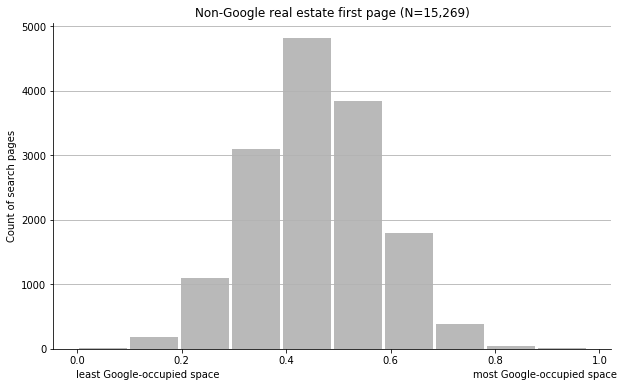

In [49]:
hist(df_pixels_fp.e1,
     title=f'Non-Google real estate first page (N={len(df_pixels):,})',
     left_right_annotations = ('least Google-occupied space',
                               'most Google-occupied space'),
     color=cat2color['organic'],
     fn_out='../data/output/figures/eq1_page.png');

In [50]:
# What percentage of pages have 50% or more of the page occupied by Google?
len(df_pixels_fp[df_pixels_fp.e1 >= .5]) / len(df_pixels) * 100

36.29576265636256

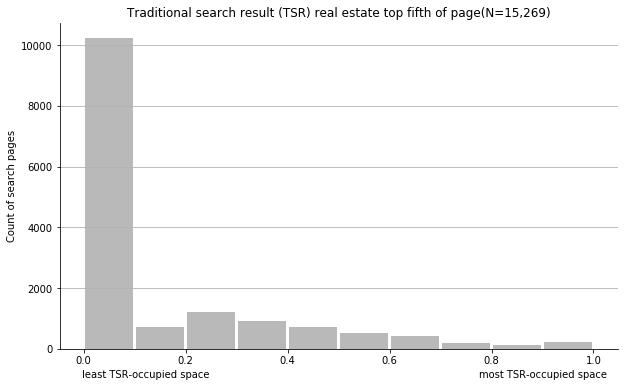

In [51]:
hist(df_pixels.e2,
     color=cat2color['organic'],
     title = f'Traditional search result (TSR) real estate top fifth of page(N={len(df_pixels):,})',
     left_right_annotations=('least TSR-occupied space',
                             'most TSR-occupied space'),
     fn_out='../data/output/figures/eq2_above.png')

In [52]:
# What percentage of pages have 95% or more of the page occupied by self-dealing?
len(df_pixels[df_pixels.e2 <= .1]) / len(df_pixels) * 100

66.97229681053113

In [53]:
len(df_pixels[df_pixels.e2 <= .1])

10226

In [54]:
df_pixels.e1.mean(), df_pixels.e1.median()

(0.23707522075591436, 0.13787139389213388)

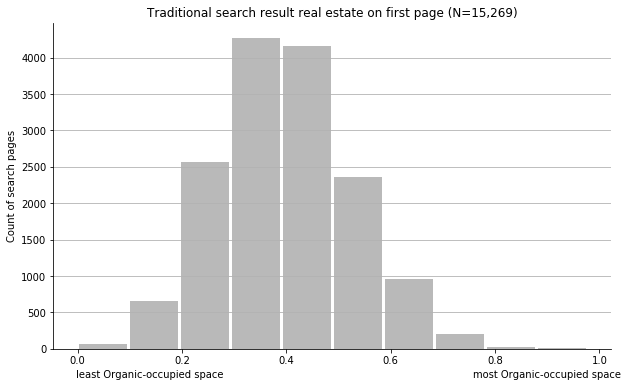

In [55]:
hist(df_pixels_fp.e2,
     color=cat2color['organic'],
     title = f'Traditional search result real estate on first page (N={len(df_pixels_fp):,})',
     left_right_annotations=('least Organic-occupied space',
                             'most Organic-occupied space'),
     fn_out='../data/output/figures/eq2_page.png')

In [56]:
len(df_pixels_fp[df_pixels_fp.e2 >= .5]) / len(df_pixels)

0.20662780797694674

## Computing confidence interval

In [57]:
def SEM(data : pd.DataFrame, 
        confidence : float = 0.95 , 
        scale : int = 100,
        return_tuple = False) -> str:
    """Calculates standard error of the mean."""
    n = len(data)
    m = data.mean()
    std_err = data.sem()
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    s = f"{scale * m:.1f} ± {h * scale :.1f}"
    if return_tuple:
        s = (m, h)
    return s

In [58]:
# index2human = {
#     'e1' : 'R1: g / (o + g)',
#     'e2' : 'R2: (g + ad) / (o + g + ad)',
# }

In [59]:
# results = {}
# for e in [f'e{i}' for i in range(1, 7)]:
#     x_goog = SEM(df_pixels[e])
#     x_goog_fp = SEM(df_pixels_fp[e])
#     results[index2human.get(e)] = {
#         'above the fold' : x_goog + '%',
#         'first page' : x_goog_fp+ '%'
#     }
# ratios = pd.DataFrame(results).T
# ratios.to_csv('../data/output/tables/ratios.csv')
# ratios

No matter what you might consider to be "Google"...
Above the fold is covered with Google properties between 64.6% and 83.2%.
For the first page it is between 40.3% and 54.7%.

# Distance

In [60]:
df.loc[:, 'y_dist'] = df.location.apply(lambda x: x['y'])

In [61]:
df.loc[df['category'] == 'link-youtube', 
       "category_standard"] = 'youtube'
df.loc[df['category'] == 'link-youtube_search_result', 
       "category_standard"] = 'youtube-search-result'

In [62]:
standard_categories = [
    "organic-search_result",
    "organic",
    "ads",
    "amp-card",
    "amp-visual_stories",
    "google-images",
    "youtube",
    "google-maps",
    'google-answer',
    "google-search",
    "google-expandable-answer",
    "amp-search_result",
    "youtube-search-result",
]

In [63]:
df.category_standard.value_counts()

google-search                   287535
google-answer                   125675
organic                         117161
google-misc                     111103
organic-search_result           106618
google-images                   104599
google-expandable-answer        102015
youtube                          78547
google-knowledge-panel-links     58957
amp-card                         50978
amp-search_result_3              39096
ads                               4566
google-maps                       1964
youtube-search-result             1629
google-video                      1090
amp-search_result                 1004
amp-visual_stories                 887
Name: category_standard, dtype: int64

In [64]:
header = 160
normalize = True

In [65]:
dist = {k : [] for k in standard_categories}
for site, _df in tqdm(df[df.area_page != 0].groupby('fn_input')):
    end_of_page = __df['position_last_element'].iloc[0] - header
    for cat in standard_categories:
        __df = _df[_df.category_standard == cat]
        if not __df.empty:
            # normalized page
            if normalize:
                y_min = ((__df.y_dist.min() - header) / end_of_page
            else:
            y_min =__df.y_dist.min()
            dist[cat].append(y_min)

100%|██████████| 15269/15269 [01:35<00:00, 160.07it/s]


In [66]:
for k, v in dist.items():
    print(k)
    print(len([_ for _ in v if _]))

organic-search_result
15264
organic
14528
ads
1452
amp-card
8580
amp-visual_stories
842
google-images
13101
youtube
9064
google-maps
1466
google-answer
14304
google-search
15267
google-expandable-answer
13703
amp-search_result
751
youtube-search-result
1399


In [67]:
for k, v in dist.items():
    fn_out = f'../data/intermediary/{k}_category_distance_raw.csv'
    pd.DataFrame({'dist_y' : v, 'category' : k}).to_csv(fn_out, index=False)

In [68]:
data = []
for cat, v in dist.items():
    dato = pd.DataFrame({'dist_y' : v}).dist_y
    mean = dato.mean()
    median = dato.median()
    err = dato.sem()
    std = dato.std()
    data.append({
        'category' : cat,
        'dist' : mean,
        'dist_median' : median,
        'min' : dato.describe()['min'],
        '25' : dato.describe()['25%'],
        '50' : dato.describe()['50%'],
        '75' : dato.describe()['75%'],
        'max' : dato.describe()['max'],
        'std' : std,
        'sem_error' : err,
        'n' : len(v)
    })
df_dist = pd.DataFrame(data)
del data

In [69]:
df_dist = df_dist[df_dist['category'] != 'organic]'].sort_values(by='dist')#.to_csv('are_these_outliers.csv', index=False)

In [70]:
# data = []
# for cat, v in dist.items():
#     print(cat)
#     dato = pd.DataFrame({'dist_y' : v}).dist_y.clip(0, 6000)
#     dato.plot(kind='hist', bins=50, xlim=(0, 6000))
#     plt.show();

organic-search_result


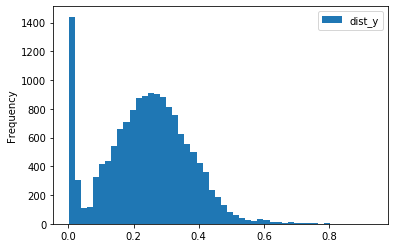

organic


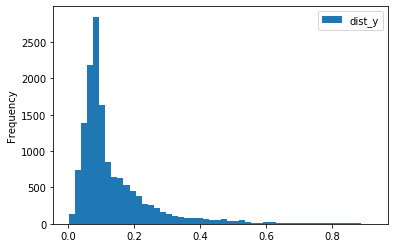

ads


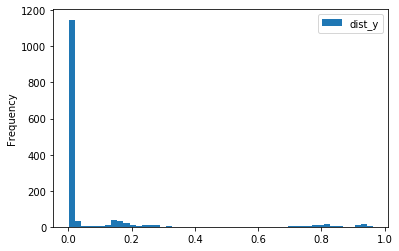

amp-card


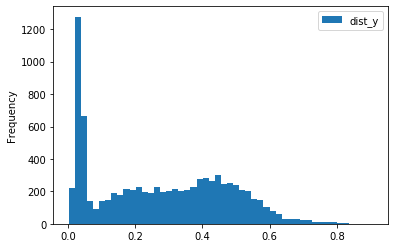

amp-visual_stories


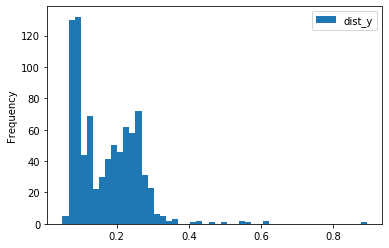

google-images


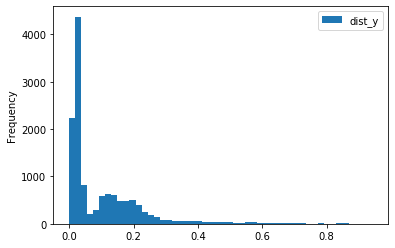

youtube


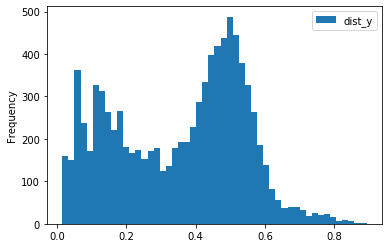

google-maps


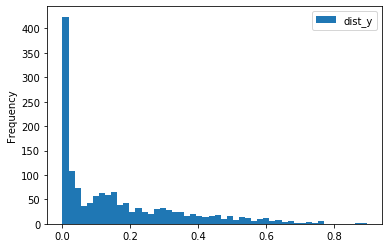

google-answer


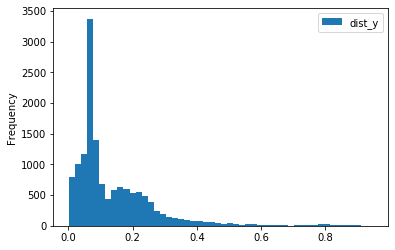

google-search


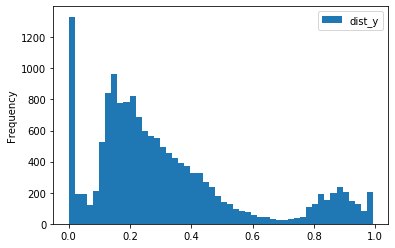

google-expandable-answer


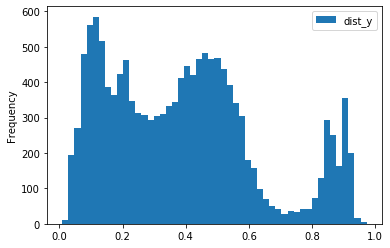

amp-search_result


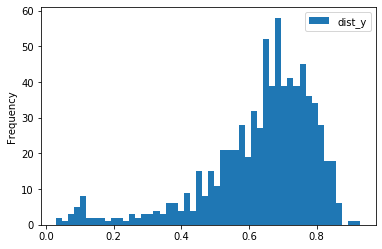

youtube-search-result


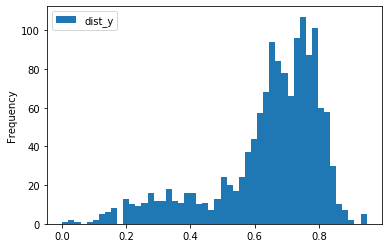

In [71]:
data = []
for cat, v in dist.items():
    print(cat)
    dato = pd.DataFrame({'dist_y' : v})
    dato.plot(kind='hist', bins=50)
    plt.show();

In [72]:
distro = pd.DataFrame()
for cat, v in dist.items():
    print(cat)
    dato = pd.DataFrame({'dist_y' : v, 'category' : cat})
    distro = distro.append(dato, sort=False)

organic-search_result
organic
ads
amp-card
amp-visual_stories
google-images
youtube
google-maps
google-answer
google-search
google-expandable-answer
amp-search_result
youtube-search-result


In [73]:
# ax = distro.boxplot(column=['dist_y'], 
#                   by='category',
#                   rot=90,
#                   figsize=(6, 12),
#                   )

# plt.gca().invert_yaxis()

In [74]:
# ax = distro.plot(kind='scatter',
#                  y='dist_y', 
#                  x='category',
#                  rot=90,
#                  s=3,
#                  color='black',
#                  alpha=.005,
#                  figsize=(6, 12))
# plt.gca().invert_yaxis()

In [75]:
df_dist

,category,dist,dist_median,min,25,50,75,max,std,sem_error,n
2,ads,0.081143,0.001384,0.000693,0.001169,0.001384,0.005514,0.962945,0.215501,0.005655,1452
5,google-images,0.102568,0.034991,-0.002545,0.023465,0.034991,0.151825,0.943902,0.130733,0.001142,13101
1,organic,0.135655,0.093083,0.001073,0.068069,0.093083,0.162355,0.924658,0.119669,0.000993,14528
8,google-answer,0.141200,0.086349,0.000911,0.061603,0.086349,0.193051,0.949056,0.136543,0.001142,14304
7,google-maps,0.161039,0.107090,0.001011,0.016622,0.107090,0.259444,0.895338,0.176688,0.004615,1466
4,amp-visual_stories,0.171092,0.162385,0.050147,0.089756,0.162385,0.235778,0.892744,0.087356,0.003010,842
0,organic-search_result,0.237905,0.243869,0.000887,0.154000,0.243869,0.326350,0.934814,0.132276,0.001071,15264
3,amp-card,0.274712,0.271743,0.001780,0.054366,0.271743,0.439113,0.908007,0.195428,0.002110,8580
9,google-search,0.316450,0.244252,-0.000259,0.146600,0.244252,0.406382,0.993326,0.254691,0.002061,15267
6,youtube,0.355021,0.401147,0.015356,0.177965,0.401147,0.502900,0.893744,0.186086,0.001955,9064


In [76]:
label2label = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'ads' : "Ads",
    'amp' : 'AMP',
    'organic' : 'Non-Google'
}

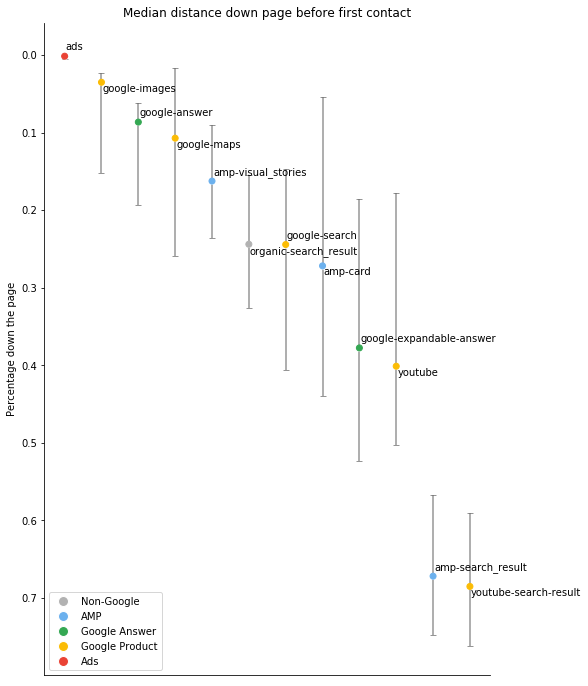

In [95]:
fig, ax = plt.subplots(figsize=(8, 12))
col = 'dist_median'
data = df_dist[df_dist.category != 'organic'].sort_values(by=col)
labels = [cat.replace('google-answer', 'answer')
                            .replace('google-expandable-answer', 'answer')
                            .split('-')[0]
                            .replace('google', 'link')
                            .replace('youtube', 'link') for cat in data.category]

colors = [cat2color.get(label) for label in labels]


plt.scatter(data.category, data[col], 
            c=colors, zorder=100)

plt.errorbar(data.category, col, 
             data=data,
             yerr=[data[col] - data['25'], 
                   data['75']- data[col]], 
             ecolor='dimgrey', color='white',
             capsize = 3,  fmt='o',
             alpha=.7)

plt.gca().invert_yaxis()
# plt.axhline(y=812, color='black', linestyle='--', alpha=.4)
# plt.annotate('Above the fold', (7.3, 800))


plt.xticks(rotation=90)
for i, (_, row) in enumerate(data.iterrows()):
#     txt = f"{row['category']} (N={row['n']:,})"
    txt = row['category']
    if i % 2 == 0:
        y = row[col] -.008
    else:
         y = row[col] +.012
    x = (1 * i)  + .03
    plt.annotate(txt, (x, y), zorder=200)

# for i, (_, row) in enumerate(data.iterrows()):
# #     txt = f"{row['category']} (N={row['n']:,})"
#     txt = row['category']
#     y = row[col] - 2
#     x = (1 * i) + .15
#     if txt == 'google-expandable_answer':
#         x = (1 * i) - 2
#     plt.annotate(txt, (x, y), zorder=200)

ax.set_ylabel("Percentage down the page")
plt.title('Median distance down page before first contact')
ax.set_axisbelow(True)
# plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.xaxis.set_visible(False)
ax.legend(handles=legend_elements, loc='lower left')
plt.savefig('../data/output/figures/distance_normalized.png')
del data;

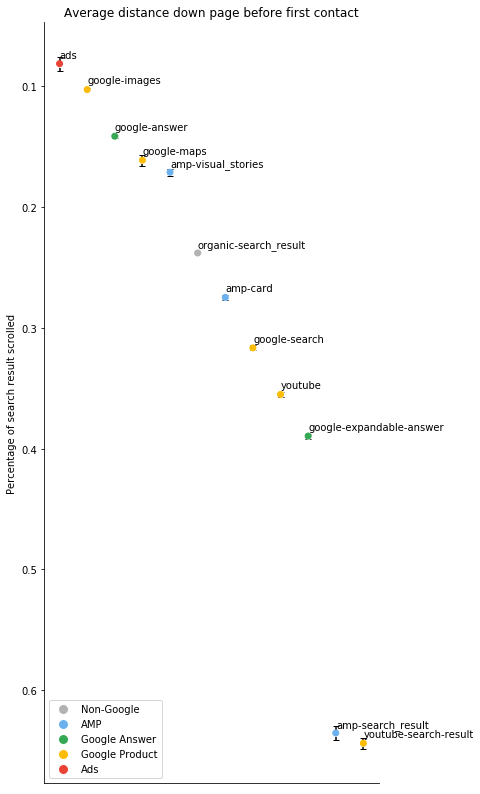

In [78]:
fig, ax = plt.subplots(figsize=(6, 14))
col = 'dist'
data = df_dist[df_dist.category != 'organic'].sort_values(by=col)
labels = [cat.replace('google-answer', 'answer')
                            .replace('google-expandable-answer', 'answer')
                            .split('-')[0]
                            .replace('google', 'link')
                            .replace('youtube', 'link') for cat in data.category]

colors = [cat2color.get(label) for label in labels]

legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label2label.get(label),
                          markerfacecolor=c, markersize=10)
                   for label, c in cat2color.items()]

plt.scatter(data.category, data[col], 
            c=colors, zorder=100)

plt.errorbar(data.category, col, 
             data=data,
             yerr='sem_error', 
             ecolor='black', color='white',
             capsize = 3,  fmt='o')

plt.gca().invert_yaxis()
# plt.axhline(y=812, color='black', linestyle='--', alpha=.4)
# plt.annotate('Above the fold', (7.3, 800))


plt.xticks(rotation=90)
for i, (_, row) in enumerate(data.iterrows()):
#     txt = f"{row['category']} (N={row['n']:,})"
    txt = row['category']
    y = row[col] -.005
    x = (1 * i)  + .005
    plt.annotate(txt, (x, y), zorder=200)

# for i, (_, row) in enumerate(data.iterrows()):
# #     txt = f"{row['category']} (N={row['n']:,})"
#     txt = row['category']
#     y = row[col] - 2
#     x = (1 * i) + .15
#     if txt == 'google-expandable_answer':
#         x = (1 * i) - 2
#     plt.annotate(txt, (x, y), zorder=200)

ax.set_ylabel("Percentage of search result scrolled")
plt.title('Average distance down page before first contact')
ax.set_axisbelow(True)
# plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.xaxis.set_visible(False)
ax.legend(handles=legend_elements, loc='lower left')
plt.savefig('../data/output/figures/distance.png')
del data;

## How many Blue Links are in a page?

In [79]:
blue_links = []
for search, _df in df[df.area_page != 0].groupby('fn_input'):
    n_blue = len(_df[_df['category_standard'].isin(blue_link_categories)])

    blue_links.append({
        'fn_input' : search,
        'n_blue_links' : n_blue
        
    })
df_bl = pd.DataFrame(blue_links)

In [80]:
df_bl.n_blue_links.mean()

7.048398716353396

In [81]:
df_bl.n_blue_links.sem()

0.015516934227310377

In [82]:
df_bl.describe()

,n_blue_links
count,15269.000000
mean,7.048399
std,1.917393
min,0.000000
25%,6.000000
50%,7.000000
75%,9.000000
max,12.000000


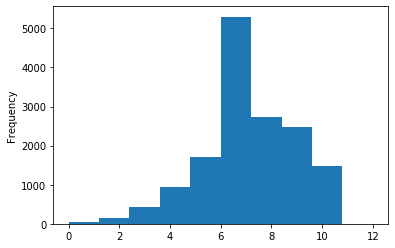

In [83]:
df_bl.n_blue_links.plot(kind='hist', bins=10)

In [84]:
df_bl[df_bl.n_blue_links == 0].fn_input.tolist()

['../data/input/google_search/iPhone-X/2019/11/14/2018-SAFF-Championship-Final/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/06/Naval-Air-Station-Pensacola/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/09/Google-Sheets/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/22/My-Sad-Christmas-Song/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2020/01/02/Nick-Gordon/html/webpage_raw.html']

# AMP
How many sites are using AMP compared to how many sites we have?

In [85]:
from urlexpander import get_domain

domains_amp = (df[df.label == 'amp']
                    .link.apply(get_domain)
                    .value_counts())

In [86]:
domains_amp.head(10)

yahoo.com          3333
usatoday.com       2377
people.com         1931
cbssports.com      1757
cnbc.com           1592
theguardian.com    1454
nytimes.com        1429
foxnews.com        1371
cnn.com            1323
espn.com           1247
Name: link, dtype: int64

In [87]:
domains_og = df[df.label == 'organic'].domain.unique()

In [88]:
n_domains_amp = len(domains_amp)
n_domains = len(set(domains_amp.index) | set(domains_og))
n_domains_amp, n_domains

(3122, 25884)

In [89]:
n_domains_amp / n_domains

0.12061505176943285

In [90]:
(df[(df.label == 'amp') &
    (df.q1_area != 0)]
    .link.apply(get_domain)
    .value_counts()
    .head(10))

google.com         515
yahoo.com          492
usatoday.com       284
people.com         265
cbssports.com      235
espn.com           230
foxnews.com        227
cnn.com            181
nypost.com         133
theguardian.com    132
Name: link, dtype: int64

In [91]:
df

,text,link,domain,xpath,category,tag,attrs,dimensions,location,area_page,...,q1_area,q2_area,q3_area,q4_area,q5_area,label,category_standard,date_parsed,date_collected,y_dist
0,testicular cancer,None,google.com,/html/body/div[10]/div/div[6]/div/div[4]/div/d...,answer-expand,div,"{'jsname': 'bVEB4e', 'class': ['QRY00e'], 'rol...","{'height': 48.0, 'width': 315.0}","{'x': 24, 'y': 3220}",15120.0,...,0.0,0.0,0.0,0.0,15120.0,answer,google-expandable-answer,2020-03-21,2019-11-28,3220
1,testicular torsion,None,google.com,/html/body/div[10]/div/div[6]/div/div[4]/div/d...,answer-expand,div,"{'jsname': 'bVEB4e', 'class': ['QRY00e'], 'rol...","{'height': 48.0, 'width': 315.0}","{'x': 24, 'y': 3269}",15120.0,...,0.0,0.0,0.0,0.0,15120.0,answer,google-expandable-answer,2020-03-21,2019-11-28,3269
2,hydrocele testis,None,google.com,/html/body/div[10]/div/div[6]/div/div[4]/div/d...,answer-expand,div,"{'jsname': 'bVEB4e', 'class': ['QRY00e'], 'rol...","{'height': 48.0, 'width': 315.0}","{'x': 24, 'y': 3318}",15120.0,...,0.0,0.0,0.0,0.0,15120.0,answer,google-expandable-answer,2020-03-21,2019-11-28,3318
3,What causes a man's balls to swell up?,None,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,answer-expand,div,"{'jsname': 'ARU61', 'class': ['mWyH1d', 'kno-a...","{'height': 48.0, 'width': 347.0}","{'x': 8, 'y': 672}",16656.0,...,16656.0,0.0,0.0,0.0,0.0,answer,google-expandable-answer,2020-03-21,2019-11-28,672
4,Will swollen testicle go away?,None,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,answer-expand,div,"{'jsname': 'ARU61', 'class': ['mWyH1d', 'kno-a...","{'height': 48.0, 'width': 347.0}","{'x': 8, 'y': 720}",16656.0,...,16656.0,0.0,0.0,0.0,0.0,answer,google-expandable-answer,2020-03-21,2019-11-28,720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193419,Britannica.com › technology › Majo...Web resul...,https://www.britannica.com/technology/diesel-e...,britannica.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,organic-search_result,div,"{'class': ['mnr-c', 'xpd', 'O9g5cc', 'uUPGi']}","{'height': 185.0, 'width': 347.0}","{'x': 8, 'y': 2908}",64195.0,...,0.0,0.0,64195.0,0.0,0.0,organic,organic-search_result,2020-03-21,2020-01-02,2908
1193420,HowStuffWorks › autoHow Diesel Engines Work | ...,https://auto.howstuffworks.com/diesel.htm,howstuffworks.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,organic-search_result,div,"{'class': ['mnr-c', 'xpd', 'O9g5cc', 'uUPGi']}","{'height': 225.0, 'width': 347.0}","{'x': 8, 'y': 3103}",78075.0,...,0.0,0.0,78075.0,0.0,0.0,organic,organic-search_result,2020-03-21,2020-01-02,3103
1193421,DieselNet › tech › diesel_enginesWeb resultsDi...,https://www.dieselnet.com/tech/diesel_engines.php,dieselnet.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,organic-search_result,div,{'data-hveid': 'CAMQAQ'},"{'height': 197.0, 'width': 347.0}","{'x': 8, 'y': 3941}",68359.0,...,0.0,0.0,0.0,68359.0,0.0,organic,organic-search_result,2020-03-21,2020-01-02,3941
1193422,DieselNet › tech › diesel_historyEarly History...,https://www.dieselnet.com/tech/diesel_history.php,dieselnet.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,organic-search_result,div,{'data-hveid': 'CAMQBw'},"{'height': 169.0, 'width': 347.0}","{'x': 8, 'y': 4139}",58643.0,...,0.0,0.0,0.0,58643.0,0.0,organic,organic-search_result,2020-03-21,2020-01-02,4139


In [92]:
res = df[df['fn_input'] == '../data/input/google_search/iPhone-X/2020/01/02/John-Cho/html/webpage_raw.html']

res.groupby('label').area_page.sum() / res.area_page.sum()

label
ads        0.072899
amp        0.122538
answer     0.105134
link       0.308350
organic    0.391079
Name: area_page, dtype: float64

In [93]:
ads        0.072899
amp        0.122538
answer     0.105134
link       0.308350
organic    0.391079

SyntaxError: invalid syntax (<ipython-input-93-24ea128b55fd>, line 1)